In [1]:
import numpy as np
import matplotlib.pyplot as plt

- deep learning 框架的一个好的设计和抽象
    - Dataset, `__getitem__`
        - veRL: `SFTDataset`, `RLHFDataset`
    - Trainer
        - veRL: `FSDPSFTTrainer`, `RayPPOTrainer`

### data & prompt

In [2]:
from transformers import AutoTokenizer

/home/whaow/anaconda3/envs/casual/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
T = AutoTokenizer.from_pretrained('Qwen/Qwen2.5-7B-Instruct')
T.special_tokens_map

{'eos_token': '<|im_end|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

In [9]:
T.eos_token

'<|im_end|>'

- `sft_dataset.py`: SFTDataset
    - eos_token: `<|im_end|>`  (151645)
        - im: instruct message（from base model to instruct model）
        - 注意不是 `<|endoftext|>`(`pad_token`, 151643)，
```python
 # apply chat template
prompt_chat = [{"role": "user", "content": prompt}]

# string
prompt_chat_str = tokenizer.apply_chat_template(prompt_chat, add_generation_prompt=True, tokenize=False)
response_chat_str = response + tokenizer.eos_token

input_ids = torch.cat((prompt_ids, response_ids), dim=-1)
attention_mask = torch.cat((prompt_attention_mask, response_attention_mask), dim=-1)
```

```
<|im_start|>system
You are a helpful assistant.
<|im_end|>
<|im_start|>user
你好，请问今天天气怎么样？
<|im_end|>
<|im_start|>assistant
你好！请告诉我您所在的城市，我可以为您查询天气。
<|im_end|>
```

### training process

- `fsdp_sft_trainer.py`
    - A lightweight one-file FSDP SFT Trainer
- logits
    - shape: `[batch_size, seq_len, vocab_size]`
- 对齐 logits 与 labels
    - `labels` (目标) 通常是 `input_ids` 向左移动一位得到 (`labels = input_ids[:, 1:].contiguous()`)。
    - `shift_logits` 是 logits 去掉最后一个时间步的预测 (`logits[..., :-1, :]`)，以与 labels 对齐。
        - `shift_logits = logits[..., :-1, :].contiguous()`
        - `shift_labels = labels.contiguous()`
    - input_ids = `[T1, T2, T3, T4]`
        - labels: [T2, T3, T4]
        - shift_logits[.., 0, :]: T2
        - shift_logits[.., 1, :]: T3
        - shift_logits[.., 2, :]: T4
- 逐 token 计算 loss
    - `nn.CrossEntropyLoss(reduction="none")`
- mask loss: mask prompt & eos token (151645, `<|im_end|>`)
    ```
    loss_mask = attention_mask.clone()
    if prompt_length > 1:
        # mask out prompt for SFT.
        loss_mask[: min(prompt_length, loss_mask.size(0)) - 1] = 0
    # mask out the last token in response
    loss_mask[min(prompt_length + response_length, loss_mask.size(0)) - 1] = 0
    ```
    - 指示哪些token的预测应该被计入损失（例如，在多轮对话中，可能只计算回答部分的损失，而不计算提示部分的损失）。它通常排除了最后一个token，因为最后一个token没有下一个token可供预测。
    - multiturn
        - mask prompts，只 supervised response 部分，即只计算 response 的 loss


### traing loss

$$
\text{CE}=-\log(P_{\text{true\_token}})
$$

- nll: negative log likelihood
- 假如训练到 0.3 的 loss 水平
    - $P_{\text{true\_token}}=\exp(-0.3)=0.7408$
- 考虑到 qwen vocab size 152064 的水平
    - 瞎猜 $\text{CE}_{\text{rand}}=-\log(\frac1{152064})=11.93$
- 从 PPL（perplexity）的角度
    - $PPL=\exp(\text{CE})$
        - CEL = 0.3 => PPL = 1.35 (能将下一个最可能的词的范围缩小到好像平均只有 1 到 2 个（1.3634）选项一样。)
- 增大batch size，起到稳定训练的作用，single sentence 容易在 learning 时有波动

In [5]:
np.exp(-0.3), np.log(152064), np.exp(0.3), np.exp(11.93)

(0.7408182206817179,
 11.932056763842207,
 1.3498588075760032,
 151751.56167916086)

- 句子级别 $w=w_1,w_2,\cdots, w_N$，其联合概率
$$
p(W)=p(w_1)p(w_2|w_1)\cdots p(w_N|w_1,\cdots,w_{N-1})  
$$
- avg ce

$$
\begin{split}
\text{avg CE}&=-\frac1N\sum_{t=1}^N\log P(w_t|w_1,\cdots,w_{\lt t})\\
&=-\frac1N\log P(W)
\end{split}
$$
- ppl = exp(ce)
$$
\begin{split}
PPL&=P(W)^{-\frac1N}=\exp(-\frac1N\log P(W))\\
&=(\exp(\log P(W)))^{-\frac1N}\\
&=\exp(-\frac1N\log P(W))
\end{split}
$$

### why -log P

- P 越远离 1（正确token对应的概率），loss 指数增加；

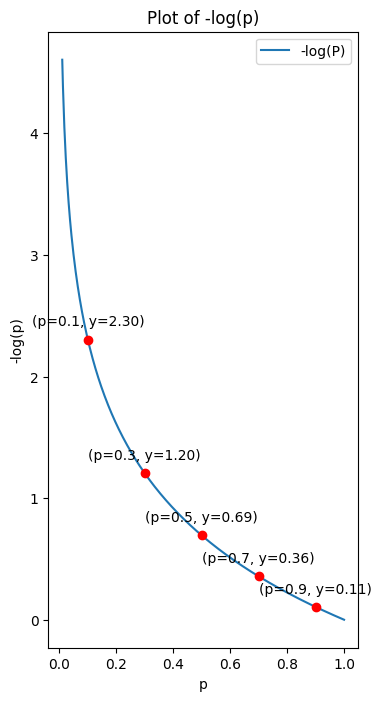

In [4]:
p_values = np.linspace(0.01, 1, 400)
neg_log_p_values = -np.log(p_values)

p_highlight = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
neg_log_p_highlight = -np.log(p_highlight)

plt.figure(figsize=(4, 8))
plt.plot(p_values, neg_log_p_values, label='-log(P)')
plt.scatter(p_highlight, neg_log_p_highlight, color='red', zorder=5)
for i, txt in enumerate(p_highlight):
    plt.annotate(f'(p={txt:.1f}, y={neg_log_p_highlight[i]:.2f})', 
                 (p_highlight[i], neg_log_p_highlight[i]),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

plt.title('Plot of -log(p)')
plt.xlabel('p')
plt.ylabel('-log(p)')
plt.grid(False)
plt.legend()

### overfitting

- 需要持续监控 training losses & val losses
    - training losses 不断地下降，但 val losses 先下降后上升；
    - 我这边的经验即是，2个epochs，就会达到 val losses 较低的水平，后续会上升；

### learning rate scheduler

- AdamW
    - `lr=1e-5`
- `get_cosine_schedule_with_warmup`

In [5]:
import math

def get_lr_at_step(
    current_step: int,
    initial_lr: float,
    num_warmup_steps: int,
    num_training_steps: int,
    min_lr_ratio: float = 0.0,
    num_cycles: float = 0.5,
):
    assert min_lr_ratio >= 0 and min_lr_ratio <= 1.0
    # 0.5
    coef = (1 - min_lr_ratio) * 0.5
    # 0.5
    intercept = (1 + min_lr_ratio) * 0.5

    if current_step < num_warmup_steps:
        # Linear warmup
        scale = float(current_step) / float(max(1, num_warmup_steps))
    else:
        # Cosine decay
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        x = math.cos(math.pi * float(num_cycles) * 2.0 * progress)
        scale = max(0.0, x * coef + intercept) # Ensure learning rate is not negative
        
    return initial_lr * scale

- cos
    - cos(pi * 0): 1, cos(pi*1): -1
    - 0 -> pi, 变量 x (即 math.cos(...) 的计算结果) 会平滑地从 1 降低到 -1。这就是所谓的“半个余弦周期”——从波峰到波谷。
    - 0.5 * x + 0.5
        - 1 (0.5 + 0.5) => 0

In [13]:
initial_lr = 1e-5
# warmup_ratio = 0.1
num_warmup_steps = 7
total_steps = 72 # This is num_training_steps in the function context

lr_values = [get_lr_at_step(step, initial_lr, num_warmup_steps, total_steps) for step in range(1, total_steps+1)]

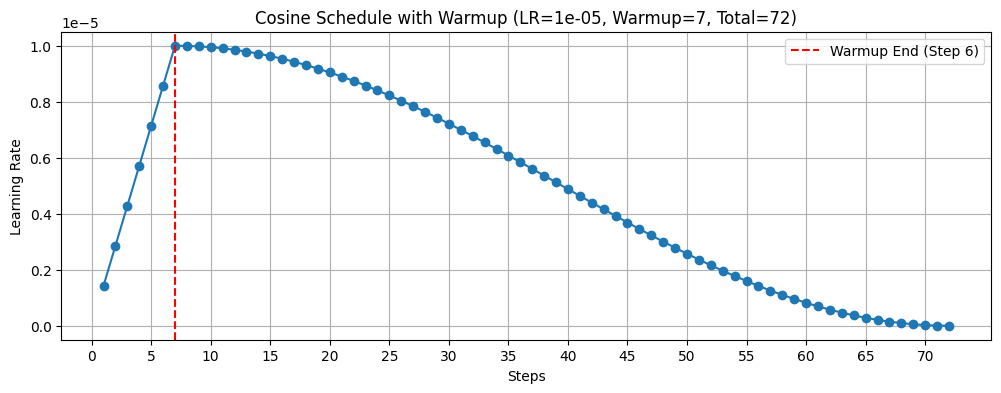

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(range(1, total_steps+1), lr_values, marker='o', linestyle='-')
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title(f"Cosine Schedule with Warmup (LR={initial_lr}, Warmup={num_warmup_steps}, Total={total_steps})")
plt.grid(True)
plt.xticks(list(range(0, total_steps, 5))) # Adjust x-axis ticks for better readability
plt.axvline(x=num_warmup_steps , color='r', linestyle='--', label=f'Warmup End (Step {num_warmup_steps-1})')
plt.legend()

### SFT vs. RL

- sft：对 response tokens 做 token 级别的监督学习；
    - rl：model 自己产生（rollout）完整的 responses，reward model 提供 reward signal；
- RL ref model 的 kl loss，不会偏离原来的模型太多；有一种定向增强模型能力的感觉
- SFT 关心 loss，RL 关心 reward
    - RL 中我们反而不关心 loss 是否下降，反而追求 loss（kl loss） 某种意义上的上升，因为它在进行探索；
- SFT memorization，RL generalization
- SFT 是 token level 的 0/1 奖励, RL 是句子 level 的离散奖励.
    - https://qiankunli.github.io/2024/07/28/llm_finetune_practice.html
    - https://zhuanlan.zhihu.com/p/26370587517